# Vehicle Detection Project


## Histogram of Oriented Gradients (HOG)

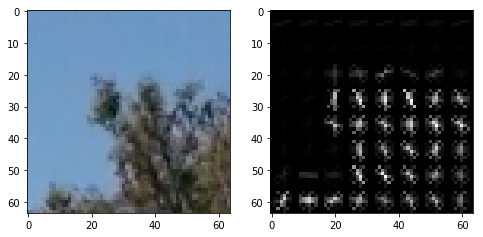

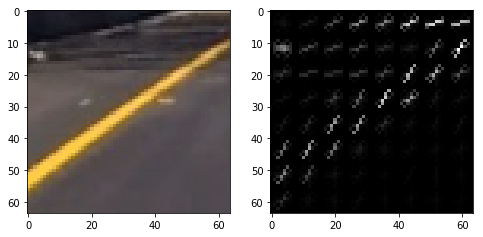

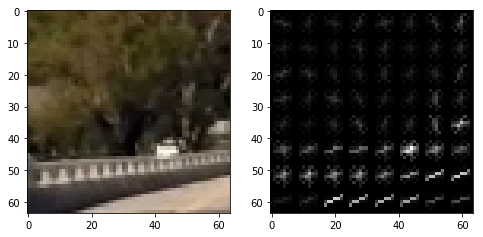

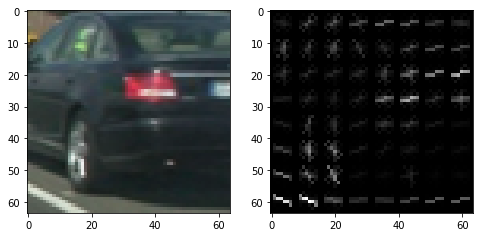

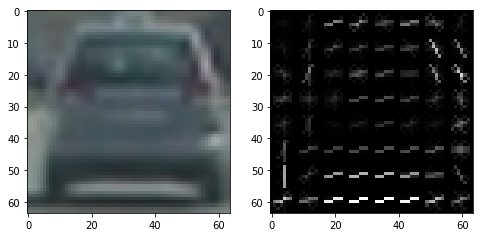

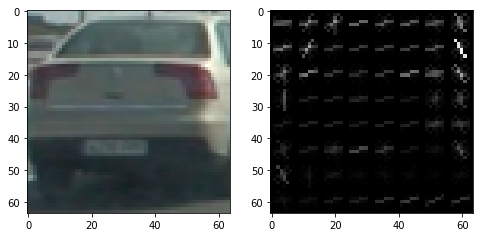

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
    from skimage.feature import hog


    # TODO: Complete the function body and returns
    return_list = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")   
                          
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        hog_features = np.ravel(hog_features)
        return hog_features, hog_image
    else:
        hog_features = np.ravel(hog_features)
        return hog_features

images = glob.glob('HOG_img/*.png')
 
# Step through the list and search for chessboard corners
for fname in images:
    name = fname.split('\\')[1]
    name = name.split('.')[0]
    ori_img = cv2.imread(fname)
#    img = mpimg.imread(fname) 
    ori_img = cv2.cvtColor(ori_img,cv2.COLOR_BGR2RGB) 
    img = cv2.cvtColor(ori_img,cv2.COLOR_BGR2YCrCb)    
    features, hog_image = get_hog_features(ori_img[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(ori_img,cmap='gray')
    ax2.imshow(hog_image,cmap='gray')

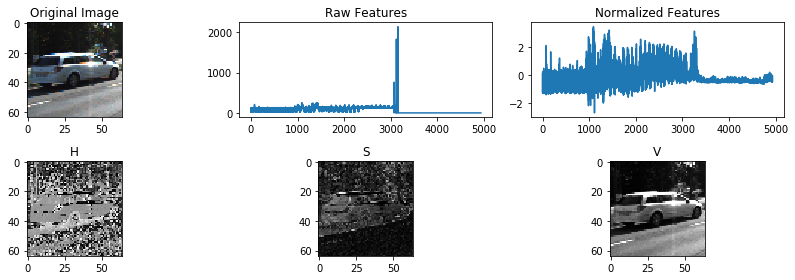

In [2]:
notcars_list = glob.glob('non-vehicles/*/*.png')
cars_list = glob.glob('vehicles/*/*.png')

n_notcar = len(notcars_list)
n_car = len(cars_list)
cars = []
notcars = []

for fname in cars_list:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cars.append(img)
    
for fname in notcars_list:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    notcars.append(img)
    

from sklearn.preprocessing import StandardScaler

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
#        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)            
        else: feature_image = np.copy(image) 
            
        # Apply get_hog_features() to get HOG features    
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hog_features = get_hog_features(HSV[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=False, feature_vec=False)
        hog_features = np.ravel(hog_features)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

car_features = extract_features(cars, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(231)
    plt.imshow(cars[car_ind])
    plt.title('Original Image')
    plt.subplot(232)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(233)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    HSV =  cv2.cvtColor(cars[car_ind], cv2.COLOR_RGB2HSV)
    plt.subplot(234)
    plt.imshow(HSV[:,:,0],cmap='gray')
    plt.title('H')
    plt.subplot(235)
    plt.imshow(HSV[:,:,1],cmap='gray')
    plt.title('S')
    plt.subplot(236)
    plt.imshow(HSV[:,:,2],cmap='gray')
    plt.title('V')    
    fig.tight_layout()

## SVC classifier

In [3]:
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)

from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

#svc = LinearSVC()
#svc.fit(scaled_X_train, y_train)
#print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))
clf = SVC(kernel='rbf',C=10)
clf.fit(scaled_X_train, y_train)
print('Test Accuracy of SVC = ', clf.score(scaled_X_test, y_test))

D:\YC\Udacity\Anaconda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Test Accuracy of SVC =  0.99268018018


## Sliding Window Search


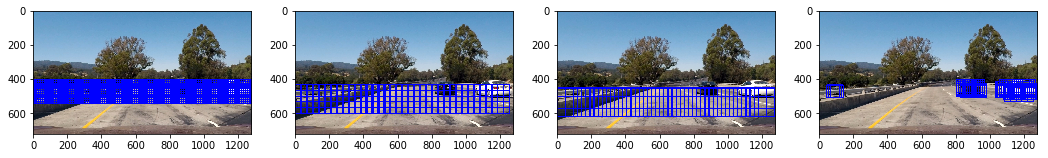

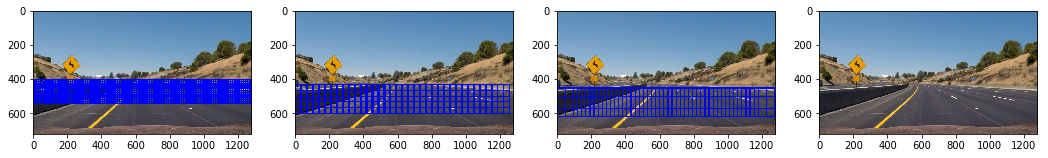

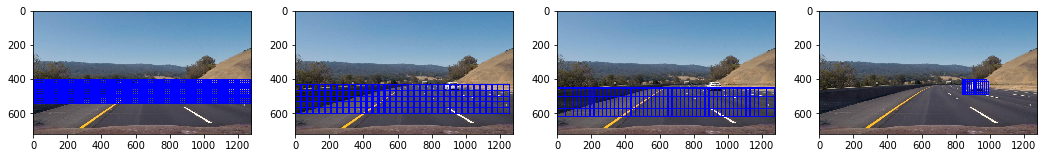

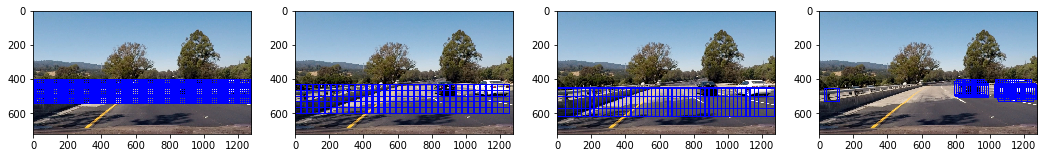

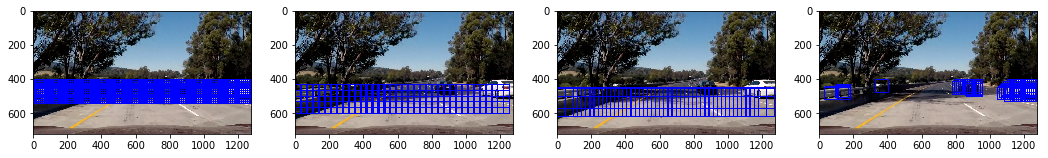

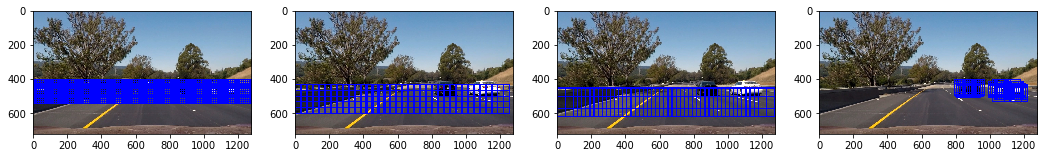

In [4]:
#from lesson_functions import *

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2,hist_range=(0, 256)):    
        #1) Define an empty list to receive features
        img_features = []
        #2) Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)                  
        else: feature_image = np.copy(image) 
            
        # Apply get_hog_features() to get HOG features    
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)    
        hog_features = get_hog_features(HSV[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=False, feature_vec=False)
        hog_features = np.ravel(hog_features)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        result = np.concatenate((spatial_features, hist_features,hog_features))

        #9) Return concatenated array of features
        return result

def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,hist_range=(0, 256))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

    
test_list = glob.glob('test_images/*.jpg')
hot_list = []
for img_file in test_list:
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    windows_1 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(75, 75), xy_overlap=(0.85, 0.85))
    window_img_1 = draw_boxes(img, windows_1, color=(0, 0, 255), thick=6)

    windows_2 = slide_window(img, x_start_stop=[None, None], y_start_stop=[430, 600], 
                    xy_window=(100, 100), xy_overlap=(0.65, 0.65))
    window_img_2 = draw_boxes(img, windows_2, color=(0, 0, 255), thick=6)
    
    windows_3 = slide_window(img, x_start_stop=[None, None], y_start_stop=[450, 650], 
                    xy_window=(120, 120), xy_overlap=(0.60, 0.60))
    window_img_3 = draw_boxes(img, windows_3, color=(0, 0, 255), thick=6)

    f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(18,10))
    ax1.imshow(window_img_1,cmap='gray')
    ax2.imshow(window_img_2,cmap='gray')
    ax3.imshow(window_img_3,cmap='gray')    
    hot_windows_1 = search_windows(img, windows_1, clf, X_scaler, cspace='YCrCb', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2)  
    hot_windows_2 = search_windows(img, windows_2, clf, X_scaler, cspace='YCrCb', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2)  
    
    hot_windows_3 = search_windows(img, windows_3, clf, X_scaler, cspace='YCrCb', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2)  
    hot_win = hot_windows_1+hot_windows_2+hot_windows_3 
    hot_list.append(hot_win)
    window_img = draw_boxes(img, hot_win, color=(0, 0, 255), thick=6)  
    ax4.imshow(window_img,cmap='gray')

## False Positive

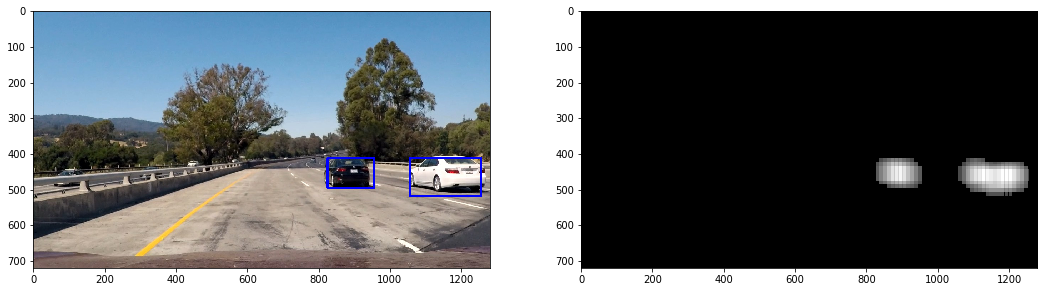

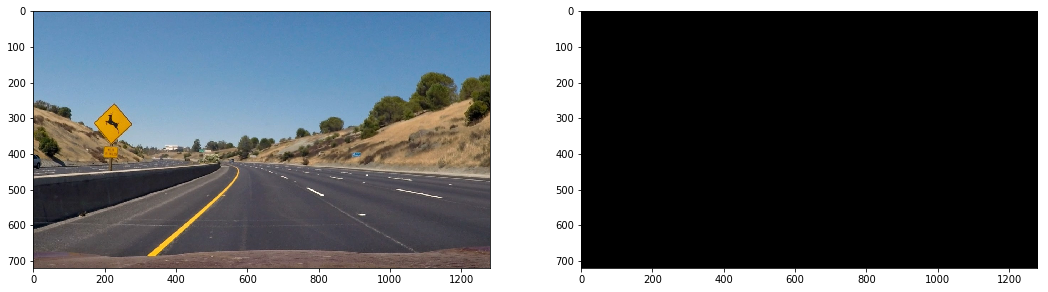

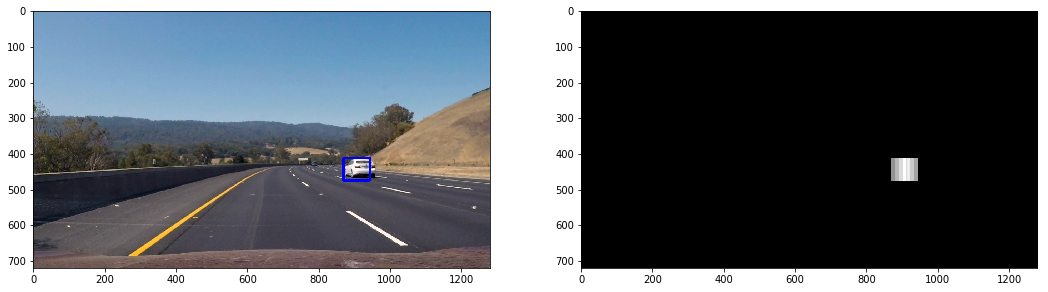

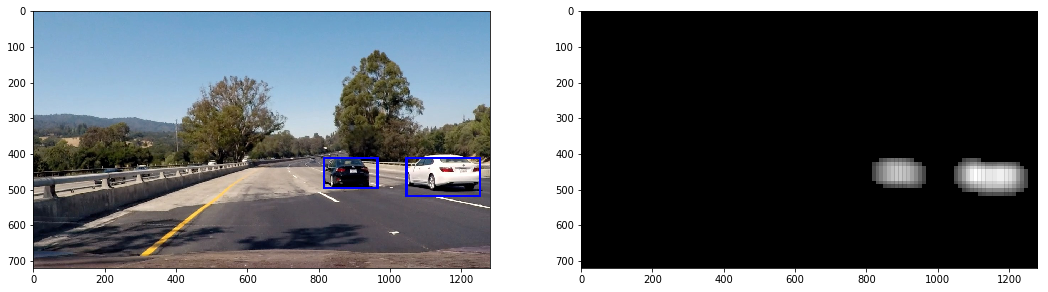

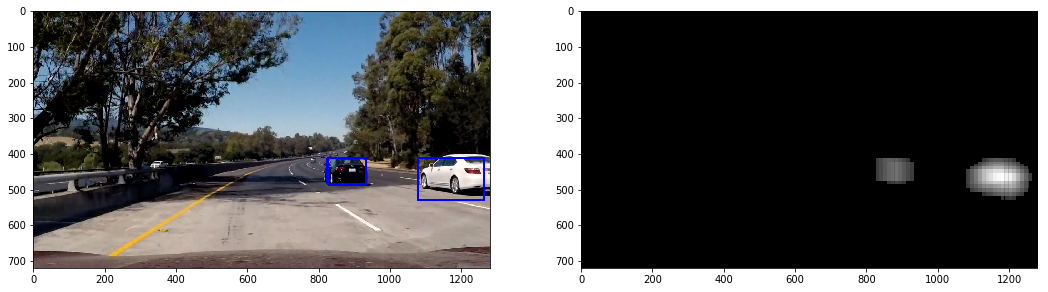

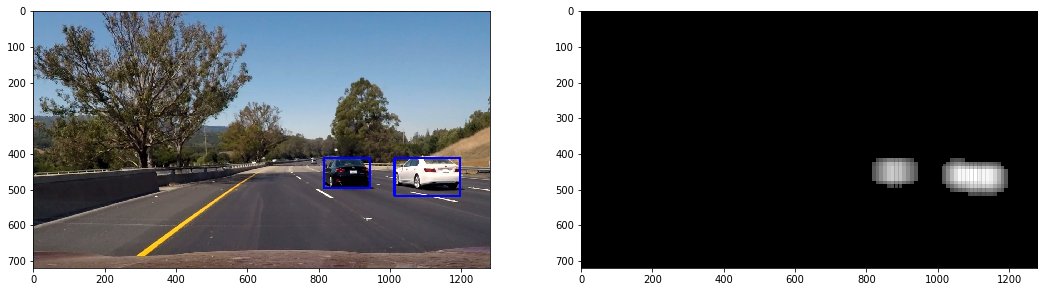

In [5]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

test_list = glob.glob('test_images/*.jpg')
i=0
for img_file in test_list:
    img = cv2.imread(img_file)
    ori_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(ori_img,cv2.COLOR_RGB2HSV)    
    heat = np.zeros_like(img[:,:,2]).astype(np.float)
    heat = add_heat(heat,hot_list[i])
    i=i+1
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,7)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(ori_img), labels)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,10))
    ax1.imshow(draw_img,cmap='gray')
    ax2.imshow(heatmap,cmap='gray')

## Testing on Video

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(img):
    ori_img = img
#    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    windows_1 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(75, 75), xy_overlap=(0.85, 0.85))
    window_img_1 = draw_boxes(img, windows_1, color=(0, 0, 255), thick=6)

    windows_2 = slide_window(img, x_start_stop=[None, None], y_start_stop=[430, 600], 
                    xy_window=(100, 100), xy_overlap=(0.65, 0.65))
    window_img_2 = draw_boxes(img, windows_2, color=(0, 0, 255), thick=6)
    
    windows_3 = slide_window(img, x_start_stop=[None, None], y_start_stop=[450, 650], 
                    xy_window=(120, 120), xy_overlap=(0.60, 0.60))
    window_img_3 = draw_boxes(img, windows_3, color=(0, 0, 255), thick=6)
    
    hot_windows_1 = search_windows(img, windows_1, clf, X_scaler, cspace='YCrCb', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2)  
    hot_windows_2 = search_windows(img, windows_2, clf, X_scaler, cspace='YCrCb', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2)  
    
    hot_windows_3 = search_windows(img, windows_3, clf, X_scaler, cspace='YCrCb', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2)  
    hot_win = hot_windows_1+hot_windows_2+hot_windows_3 
   
    HSV = cv2.cvtColor(ori_img,cv2.COLOR_RGB2HSV)    
    heat = np.zeros_like(HSV[:,:,2]).astype(np.float)
    heat = add_heat(heat,hot_win)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,7)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(ori_img), labels)
    
    return  draw_img

input_video = "project_video.mp4"
output_video = 'output_{}'.format(input_video)
clip = VideoFileClip(input_video)
clip.fl_image(process_video).write_videofile(output_video, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:10:48<00:27, 27.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

